In [302]:
import numpy as np
import os
import glob
import json
from collections import Counter


import cv2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


In [25]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [107]:
DATA_ROOT = "/media/godel/HDD/jimmy/Objaverse"

SELECTED_SEEN_CATEGORY_NUM = 10
SELECTED_NOVEL_CATEGORY_NUM = 10

MIN_CATEGORY_SIZE = 50


IMAGE_MEAN = np.array([0.485, 0.456, 0.406])
IMAGE_STD = np.array([0.229, 0.224, 0.225])


In [3]:
with open(os.path.join(DATA_ROOT, "uid_wo_image.json"), "r") as fd:
    no_image_uid = json.load(fd)

In [4]:
all_image_path = glob.glob(os.path.join(DATA_ROOT, "data", "*/*/*.jpeg"))

In [5]:
all_image_path = [ p for p in all_image_path if p.split(os.sep)[-2] not in no_image_uid ]

In [6]:
len(all_image_path)

45306

In [7]:
def getImageSize(fn):
    # return imageio.v3.imread(fn).shape
    return cv2.imread(fn).shape

all_image_size = Parallel(n_jobs=32)(delayed(getImageSize)(p) for p in tqdm(all_image_path))

  0%|          | 0/45306 [00:00<?, ?it/s]

In [8]:
Counter(all_image_size)

Counter({(1080, 1920, 3): 41695,
         (486, 864, 3): 24,
         (576, 1024, 3): 3205,
         (720, 1024, 3): 12,
         (573, 1024, 3): 79,
         (405, 720, 3): 50,
         (810, 1440, 3): 77,
         (574, 1024, 3): 23,
         (360, 640, 3): 84,
         (591, 1024, 3): 1,
         (144, 256, 3): 7,
         (532, 1024, 3): 1,
         (598, 1024, 3): 2,
         (572, 1024, 3): 3,
         (852, 1024, 3): 1,
         (612, 1024, 3): 1,
         (640, 1024, 3): 1,
         (252, 448, 3): 11,
         (626, 1024, 3): 1,
         (605, 1024, 3): 1,
         (569, 1024, 3): 1,
         (563, 1024, 3): 1,
         (581, 1024, 3): 1,
         (617, 1024, 3): 2,
         (599, 1024, 3): 1,
         (673, 1024, 3): 1,
         (600, 1024, 3): 1,
         (587, 1024, 3): 1,
         (561, 1024, 3): 2,
         (655, 1024, 3): 1,
         (686, 1024, 3): 1,
         (912, 1024, 3): 2,
         (1025, 1024, 3): 1,
         (578, 1024, 3): 1,
         (593, 1024, 3): 1,
        

In [9]:
SELECTED_IMAGE_SIZE  = (1080, 1920, 3)
OUTPUT_IMAGE_SIZE = (144, 256, 3)

In [10]:
len(all_image_size)

45306

In [11]:
image_match_size_idx = [ i for i in range(len(all_image_size)) if all_image_size[i] == SELECTED_IMAGE_SIZE ]

In [12]:
category2path = {}

for idx in image_match_size_idx:

    fn = all_image_path[idx]
    cate = fn.split(os.sep)[-3]

    if cate not in category2path:
        category2path[cate] = []
    
    category2path[cate].append(fn)


In [13]:
len(category2path)

1154

In [14]:
cate2size = { k:len(v) for k, v in category2path.items() }

In [15]:
def getImage(fn):
    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    # img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(img, OUTPUT_IMAGE_SIZE[:2][::-1]).astype(float) / 255.0
    norm_img = (resized_img - IMAGE_MEAN) / IMAGE_STD
    return norm_img

In [ ]:
# cate2matchImage = {}

# for k in category2path:
#     if k not in cate2matchImage:
#         cate2matchImage[k] = []
    
#     cate2matchImage[k] = Parallel(n_jobs=32)(delayed(getImage)(p) for idx in tqdm(image_match_size_idx))


In [16]:
all_match_image = Parallel(n_jobs=32)(delayed(getImage)(all_image_path[idx]) for idx in tqdm(image_match_size_idx))

  0%|          | 0/41695 [00:00<?, ?it/s]

In [17]:
all_match_image = np.stack(all_match_image)

In [18]:
all_match_image.shape

(41695, 144, 256, 3)

In [22]:
from torchvision.models import resnet50
import torch.nn as nn
import torch


In [23]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = resnet50(weights="IMAGENET1K_V1")

    # (B, C, H, W)
    def forward(self, x):
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x = self.encoder.layer1(x)
        x = self.encoder.layer2(x)
        x = self.encoder.layer3(x)
        x = self.encoder.layer4(x)

        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)

        return x
    

In [24]:
encoder = Encoder()

In [28]:
BATCH_SIZE = 128

encoder = encoder.eval()
encoder = encoder.cuda()
batch_num = np.ceil(all_match_image.shape[0] / BATCH_SIZE).astype(int)

all_emb = []

with torch.no_grad():

    for bidx in range(batch_num):
        inp_batch = all_match_image[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE]
        inp_batch_ten = torch.from_numpy(inp_batch).float().permute(0,3,1,2)
        inp_batch_ten = inp_batch_ten.cuda()
        emb = encoder(inp_batch_ten)

        all_emb.append(emb.cpu().numpy())


In [ ]:
all_emb = np.concatenate(all_emb, axis=0)

In [34]:
REDUCED_DIM = 2

dim_reduce_method = PCA(n_components=REDUCED_DIM)
# all_red_image = dim_reduce_method.fit_transform(all_match_image.reshape(all_match_image.shape[0], -1))

all_red_image = dim_reduce_method.fit_transform(all_emb)

In [36]:
# plt.scatter(all_red_image[:,0], all_red_image[:,1])

In [37]:
all_red_image = all_emb

In [38]:
cate2redImg = {}

for i in range(len(image_match_size_idx)):
    idx = image_match_size_idx[i]

    fn = all_image_path[idx]
    cate = fn.split(os.sep)[-3]

    if cate not in cate2redImg:
        cate2redImg[cate] = []
    
    red_img = all_red_image[i]

    cate2redImg[cate].append(red_img)


for k in cate2redImg:
    cate2redImg[k] = np.stack(cate2redImg[k])


cate2meanRedImg = {}

for k in cate2redImg:
    cate2meanRedImg[k] = cate2redImg[k].mean(axis=0)

/data/jimmy/.conda/envs/NovelObject/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


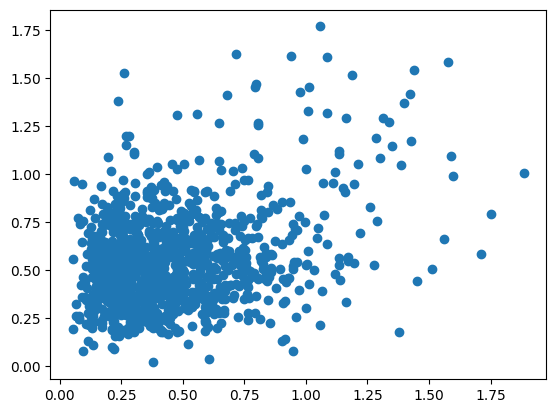

In [39]:
meanRedImg = np.stack(cate2meanRedImg.values())

plt.scatter(meanRedImg[:,0], meanRedImg[:,1])

In [ ]:
# Category with dataset size larger than 50

In [108]:
qualified_category = [ (k,v) for k,v in cate2size.items() if v >= MIN_CATEGORY_SIZE ]

In [109]:
qualified_category

[('ladder', 55),
 ('bouquet', 62),
 ('heart', 107),
 ('drum_musical_instrument', 89),
 ('trash_can', 55),
 ('fireplace', 73),
 ('candle', 51),
 ('wolf', 92),
 ('eagle', 51),
 ('stagecoach', 53),
 ('chocolate_cake', 63),
 ('fan', 86),
 ('shark', 94),
 ('glove', 51),
 ('wedding_cake', 50),
 ('piano', 88),
 ('pickup_truck', 105),
 ('pop_soda', 76),
 ('gun', 90),
 ('monkey', 63),
 ('musical_instrument', 59),
 ('cupcake', 62),
 ('pot', 51),
 ('motor_scooter', 64),
 ('deer', 51),
 ('cock', 60),
 ('pliers', 51),
 ('table', 66),
 ('solar_array', 70),
 ('pony', 98),
 ('camera_lens', 56),
 ('shirt', 70),
 ('watch', 86),
 ('elephant', 100),
 ('tractor_farm_equipment', 73),
 ('teapot', 75),
 ('dollhouse', 54),
 ('award', 61),
 ('mug', 108),
 ('bus_vehicle', 68),
 ('motor_vehicle', 98),
 ('keg', 93),
 ('skateboard', 111),
 ('bat_animal', 67),
 ('banana', 119),
 ('toilet', 105),
 ('wedding_ring', 110),
 ('goldfish', 54),
 ('turtle', 77),
 ('jewelry', 62),
 ('doughnut', 122),
 ('wall_clock', 55),
 ('

In [110]:
len(qualified_category)

274

In [111]:
qualifiedMeanEmb = np.stack([ cate2meanRedImg[q[0]] for q in qualified_category ])

In [269]:
# np.random.seed(20001004)
# np.random.seed(19970203)
# np.random.seed(20230408)
# np.random.seed(20230407)
np.random.seed(20230409)

SELECTED_SEEN_CATEGORY = np.random.choice([ q[0] for q in qualified_category], SELECTED_SEEN_CATEGORY_NUM, replace=False)

SELECTED_SEEN_CATEGORY

array(['gameboard', 'can', 'jacket', 'chocolate_cake', 'glove', 'fish',
       'helicopter', 'lamppost', 'eagle', 'basketball'], dtype='<U43')

In [270]:
qualifiedMeanEmb.shape

(274, 2048)

In [282]:
SELECTED_UNSEEN_CATEGORY = []

for c in SELECTED_SEEN_CATEGORY:
    cidx = next(i for i, v in enumerate(qualified_category) if v[0] == c )
    
    selected_emb = qualifiedMeanEmb[cidx]
    dist = ((qualifiedMeanEmb - selected_emb) ** 2).sum(axis=-1)

    most_similar_cate_idx = dist.argsort()[2]

    SELECTED_UNSEEN_CATEGORY.append(qualified_category[most_similar_cate_idx][0])
    

In [283]:
SELECTED_SEEN_CATEGORY

array(['gameboard', 'can', 'jacket', 'chocolate_cake', 'glove', 'fish',
       'helicopter', 'lamppost', 'eagle', 'basketball'], dtype='<U43')

In [284]:
SELECTED_UNSEEN_CATEGORY

['checkerboard',
 'cylinder',
 'sportswear',
 'wedding_cake',
 'dress',
 'owl',
 'airplane',
 'lamp',
 'owl',
 'pumpkin']

In [285]:
list(zip(SELECTED_SEEN_CATEGORY, SELECTED_UNSEEN_CATEGORY))

[('gameboard', 'checkerboard'),
 ('can', 'cylinder'),
 ('jacket', 'sportswear'),
 ('chocolate_cake', 'wedding_cake'),
 ('glove', 'dress'),
 ('fish', 'owl'),
 ('helicopter', 'airplane'),
 ('lamppost', 'lamp'),
 ('eagle', 'owl'),
 ('basketball', 'pumpkin')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


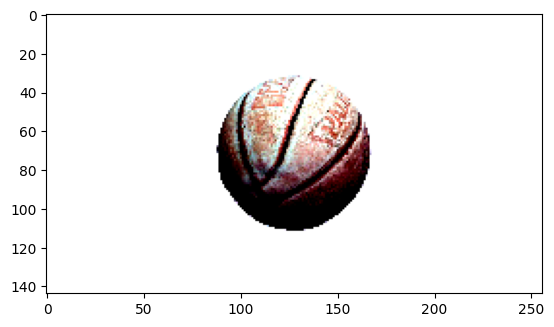

In [289]:
img = getImage(category2path["basketball"][7])
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


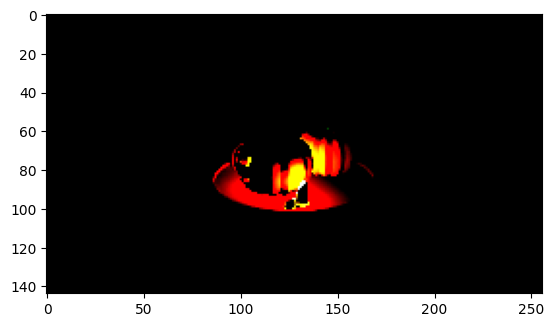

In [291]:
img = getImage(category2path["pumpkin"][6])
plt.imshow(img)

In [292]:
SELECTED_SEEN_CATEGORY_PAIR = [
    ('wolf', 'horse'),
    ('dress_hat', 'wedding_cake'),
    ('lightbulb', 'award'),
    ('ring', 'earphone'),
    ('globe', 'tomato'),
    ('table_lamp', 'wineglass'),
    ('gargoyle', 'lion'),
    ('bookcase', 'armoire'),
    ('bus_vehicle', 'bullet_train'),
    ('fighter_jet', 'shark'),
    ('desk', 'piano'),
    ('penguin', 'bird'),
    ('chinaware', 'pot'),
    ('lamppost', 'antenna'),
    ('basketball', 'pumpkin'),
]

In [293]:
len(SELECTED_SEEN_CATEGORY_PAIR)

15

In [294]:
for c in SELECTED_SEEN_CATEGORY_PAIR:
    print(c[0], cate2size[c[0]], c[1], cate2size[c[1]])


wolf 92 horse 76
dress_hat 52 wedding_cake 50
lightbulb 73 award 61
ring 116 earphone 83
globe 105 tomato 50
table_lamp 77 wineglass 92
gargoyle 69 lion 100
bookcase 95 armoire 53
bus_vehicle 68 bullet_train 53
fighter_jet 105 shark 94
desk 66 piano 88
penguin 92 bird 74
chinaware 56 pot 51
lamppost 102 antenna 154
basketball 62 pumpkin 105


In [295]:
sum( cate2size[c[0]] for c in SELECTED_SEEN_CATEGORY_PAIR)

1230

In [296]:
sum( cate2size[c[1]] for c in SELECTED_SEEN_CATEGORY_PAIR)

1184

In [298]:
all_selected_seen_cate2uid = {}
all_selected_unseen_cate2uid = {}

for c in SELECTED_SEEN_CATEGORY_PAIR:
    all_selected_seen_cate2uid[c[0]] = [ p.split(os.sep)[-2] for p in category2path[c[0]] ]
    all_selected_unseen_cate2uid[c[1]] = [ p.split(os.sep)[-2] for p in category2path[c[1]] ]


In [309]:
def data_spliter(allCate2Uid):

    train_cate2uid = {}
    valid_cate2uid = {}
    test_cate2uid = {}

    for c in allCate2Uid:
        train_cate2uid[c], valid_cate2uid[c] = train_test_split(allCate2Uid[c], test_size=0.2, random_state=2023)
        valid_cate2uid[c], test_cate2uid[c] = train_test_split(valid_cate2uid[c], test_size=0.5, random_state=2023)
        
    return train_cate2uid, valid_cate2uid, test_cate2uid


In [310]:
train_seen_data, valid_seen_data, test_seen_data = data_spliter(all_selected_seen_cate2uid)
train_unseen_data, valid_unseen_data, test_unseen_data = data_spliter(all_selected_unseen_cate2uid)

In [316]:
OUTPUT_DIR = "./"

In [317]:
with open(os.path.join(OUTPUT_DIR, "train_seen_uid.json"), "w") as fd:
    json.dump(train_seen_data, fd, indent=4)

with open(os.path.join(OUTPUT_DIR, "valid_seen_uid.json"), "w") as fd:
    json.dump(valid_seen_data, fd, indent=4)

with open(os.path.join(OUTPUT_DIR, "test_seen_uid.json"), "w") as fd:
    json.dump(test_seen_data, fd, indent=4)

In [320]:
with open(os.path.join(OUTPUT_DIR, "train_unseen_uid.json"), "w") as fd:
    json.dump(train_unseen_data, fd, indent=4)

with open(os.path.join(OUTPUT_DIR, "valid_unseen_uid.json"), "w") as fd:
    json.dump(valid_unseen_data, fd, indent=4)

with open(os.path.join(OUTPUT_DIR, "test_unseen_uid.json"), "w") as fd:
    json.dump(test_unseen_data, fd, indent=4)